In [29]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [30]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from Behavior.behavior import get_extent, density_map, get_idxs_behav_state
from spatial import gaussian_kernel_2D, get_field_patches
from target import get_spike_counts

from population import unit_response_matrix, activity_at_phase

In [31]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [82]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass
selected

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [105]:
session = selected[15]
exp_states = {'SIL': 0, 'BGR': 1, 'TGT': 2}
width = 100  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
exp_state = 'BGR'
speed_thresh = 0.05

animal = session.split('_')[0]
s_path           = os.path.join(source, animal, session)
meta_file        = os.path.join(source, animal, session, 'meta.h5')
units_file       = os.path.join(source, animal, session, 'units.h5')
moseq_file       = os.path.join(source, animal, session, 'MoSeq.h5')
moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
with h5py.File(moseq_file, 'r') as f:
    moseq = np.array(f['moseq'])
        
# speed to filter out
dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
dt = np.diff(moseq[:, 0])
speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()

# auditory state (BGR, SIL etc.) and speed filter
idxs_idle_ev  = np.where(speed_smooth[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
idxs_state_ev = np.where(events[:, 1] == exp_states[exp_state])[0]
idxs_state_ev = np.intersect1d(idxs_idle_ev, idxs_state_ev)
     
# behavioral state
idxs_tl_tgt_succ = []
idxs_tl_pellet   = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_tl_tgt_succ += list(range(tgt_rec[2], tgt_rec[3]))
    idxs_tl_pellet   += list(range(tgt_rec[3] + 1*100, tgt_rec[3] + 6*100))
idxs_tl_tgt_succ = np.array(idxs_tl_tgt_succ)
idxs_tl_pellet   = np.array(idxs_tl_pellet)

idxs_AL_tl = get_idxs_behav_state(source, session, idxs_tl_tgt_succ, fit_type=ft, fit_parm=fp, sigma=0.3, margin=10, bin_count=100)
idxs_PC_tl = get_idxs_behav_state(source, session, idxs_tl_pellet, fit_type=ft, fit_parm=fp, sigma=0.3, margin=10, bin_count=100)

idxs_AL_ev = np.array([k for k, x in enumerate(events) if x[2] in idxs_AL_tl], dtype=np.int32)
idxs_PC_ev = np.array([k for k, x in enumerate(events) if x[2] in idxs_PC_tl], dtype=np.int32)

# final separation
idxs_AL_bgr_ev = np.intersect1d(idxs_AL_ev, idxs_state_ev)
idxs_PC_bgr_ev = np.intersect1d(idxs_PC_ev, idxs_state_ev)
idxs_other_ev  = np.setdiff1d(idxs_state_ev, idxs_AL_ev)

sp_AL_mean    = speed_smooth[events[idxs_AL_bgr_ev][:, 2].astype(np.int32)].mean()
sp_PC_mean    = speed_smooth[events[idxs_PC_bgr_ev][:, 2].astype(np.int32)].mean()
sp_other_mean = speed_smooth[events[idxs_other_ev][:, 2].astype(np.int32)].mean()

print("%s with speed filter at %.2f m/s we get" % (session, speed_thresh))
print("AL: %d pulses, PC: %d pulses, other: %d pulses" % (len(idxs_AL_bgr_ev), len(idxs_PC_bgr_ev), len(idxs_other_ev)))
print("Mean speed for AL: %.3f, PC: %.3f, other: %.3f m/s" % (sp_AL_mean, sp_PC_mean, sp_other_mean))

009265_hippoSIT_2023-03-09_20-03-08 with speed filter at 0.05 m/s we get
AL: 1074 pulses, PC: 292 pulses, other: 1554 pulses
Mean speed for AL: 0.024, PC: 0.033, other: 0.032 m/s


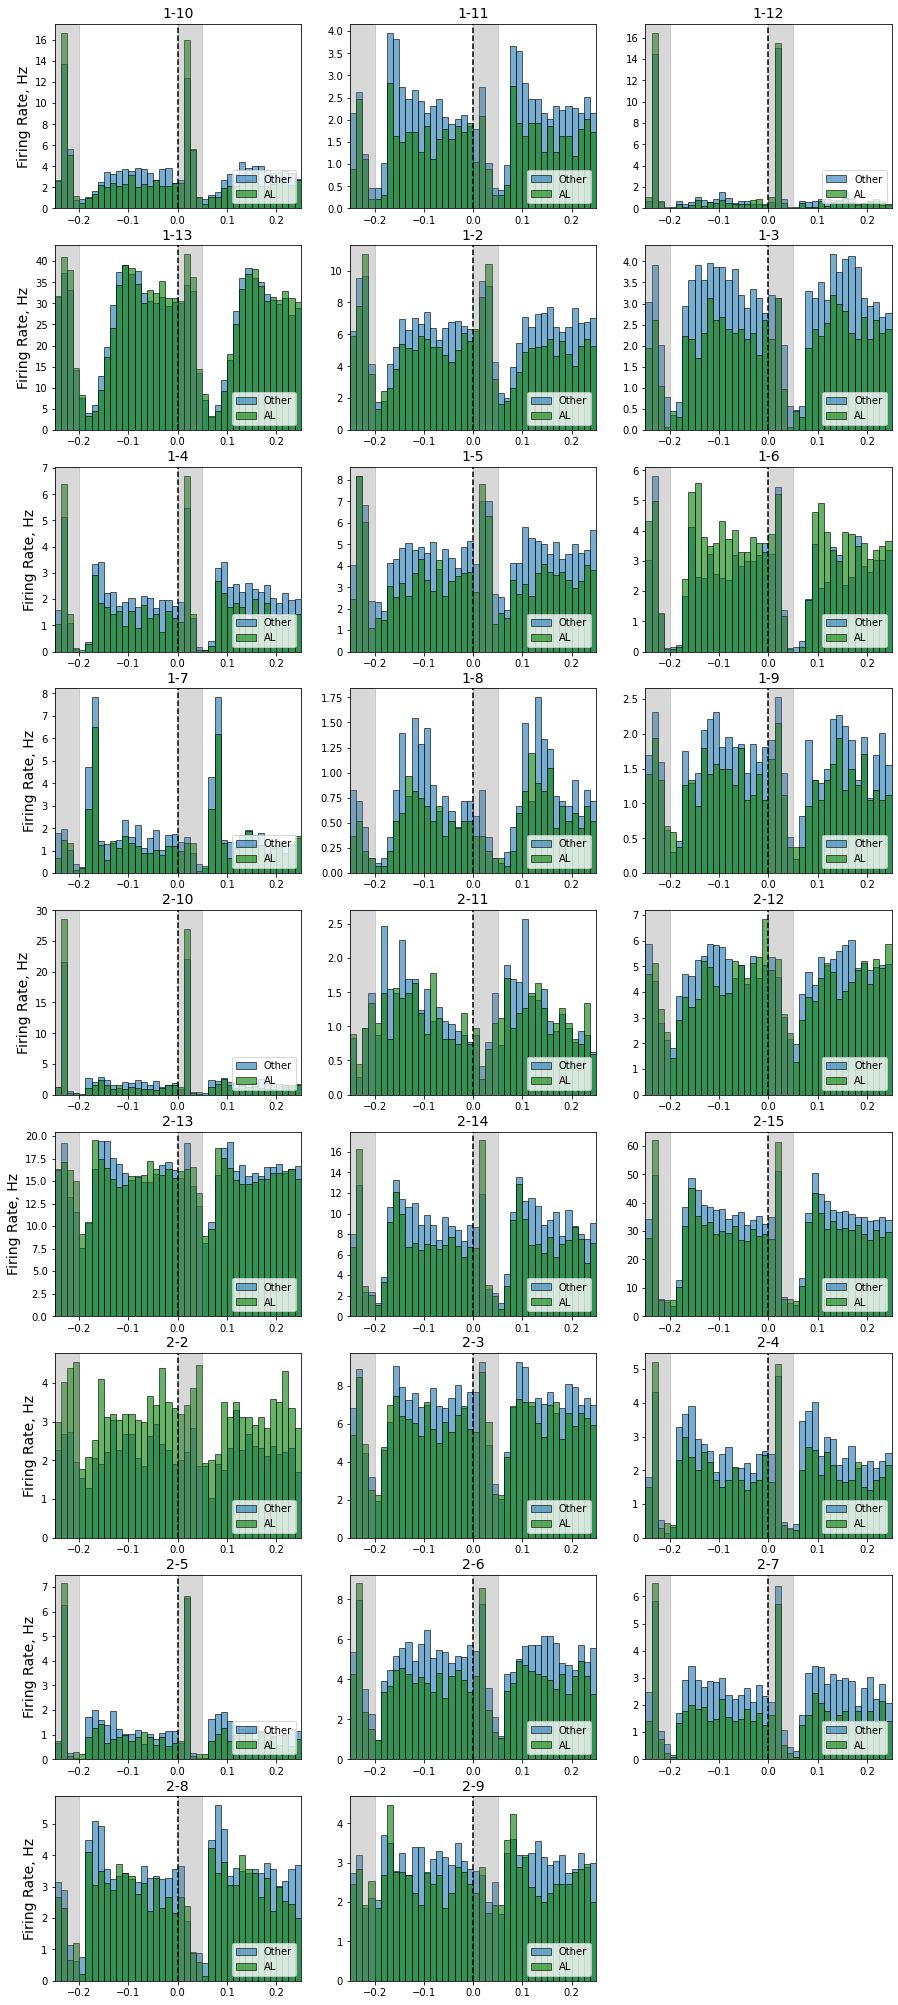

In [104]:
psth_times_A = events[idxs_other_ev][:, 0] 
psth_times_B = events[idxs_AL_bgr_ev][:, 0]
to_plot = [name for name in unit_names if int(name[0]) < 3]

hw, bc = 0.25, 41
cols = 3
rows = int(np.ceil(len(to_plot)/3))
fig = plt.figure(figsize=(15, rows*4))

for i, unit_name in enumerate(to_plot[:]):
    bins, counts_A = get_spike_counts(spike_times[unit_name], psth_times_A, hw, bc)
    bins, counts_B = get_spike_counts(spike_times[unit_name], psth_times_B, hw, bc)
    
    ax = fig.add_subplot(rows, cols, i+1)
    
    ax.hist(bins[:-1], bins=bins, weights=counts_A, edgecolor='black', color='tab:blue', alpha=0.6, label='Other')
    ax.hist(bins[:-1], bins=bins, weights=counts_B, edgecolor='black', color='green', alpha=0.6, label='AL')
    ax.axvline(0, color='black', ls='--')
    ax.axvspan(0, 0.05, alpha=0.3, color='gray')
    ax.axvspan(0 - hw, 0 - hw + 0.05, alpha=0.3, color='gray')
    ax.set_title(unit_name, fontsize=14)
    ax.legend(loc='lower right', prop={'size': 10})
    ax.set_xlim(-hw, hw)
    if i % 3 == 0:
        ax.set_ylabel("Firing Rate, Hz", fontsize=14)